In [81]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.stats
import math

### Define database


In [100]:
# train = 800
x_train = np.arange(0, 2, 1/400)
y_train = (-1 + ((2/3) * np.sin(2 * x_train * (np.pi))) + (1.6 * np.random.random_sample((800, )) - 0.8))
x_train_rbf = x_train.reshape(800,1)
y_train_rbf = y_train.reshape(800,1)
# test = 200
x_test = np.arange(0, 2, 0.01)
y_test = (-1 + ((2/3) * np.sin(2 * x_test * (np.pi))) + (1.6 * np.random.random_sample((200, )) - 0.8))
x_test_rbf = x_test.reshape(200,1)
y_test_rbf = y_test.reshape(200,1)

### Plot train and test dat

Text(0.5, 1.0, 'Test data')

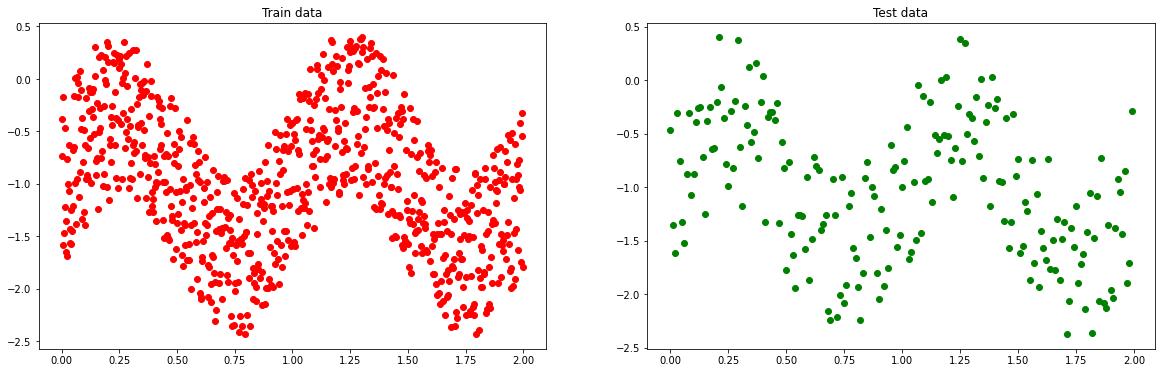

In [101]:
plt.rcParams["figure.figsize"] = (20,6) 
plt.subplot(1,2,1)
plt.scatter(x_train_rbf, y_train_rbf, c='r')
plt.title("Train data")

plt.subplot(1,2,2)
plt.scatter(x_test_rbf, y_test_rbf,c='g')
plt.title("Test data")

### RBF

In [102]:
def Kmeans(X, k):
  clusters = np.random.choice(np.squeeze(X), size=k)
  prevClusters = clusters.copy()
  stds = np.zeros(k)
  converged = False
  while not converged:
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    for i in range(k):
      pointsForCluster = X[closestCluster == i]
      if len(pointsForCluster) > 0:
        clusters[i] = np.mean(pointsForCluster, axis=0)
    converged = np.linalg.norm(clusters - prevClusters) < 1e-6
    prevClusters = clusters.copy()
  distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
  closestCluster = np.argmin(distances, axis=1)
  clustersWithNoPoints = []
  for i in range(k):
    pointsForCluster = X[closestCluster == i]
    if len(pointsForCluster) < 2:
      clustersWithNoPoints.append(i)
      continue
    else:
      stds[i] = np.std(X[closestCluster == i])
  if len(clustersWithNoPoints) > 0:
    pointsToAverage = []
    for i in range(k):
      if i not in clustersWithNoPoints:
        pointsToAverage.append(X[closestCluster == i])
    pointsToAverage = np.concatenate(pointsToAverage).ravel()
    stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
  return clusters, stds

def GMM(x, k):
  gmm = GaussianMixture(n_components=k).fit(x)
  clusters = []
  for i in range(k):
    d = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(x)
    clusters.append(x[np.argmax(d)])
  dMax = max([np.abs(cluster1 - cluster2) for cluster1 in clusters for cluster2 in clusters])
  stds = np.repeat(dMax / np.sqrt(2*k), k)   
  clusters = np.array(clusters) 
  return clusters, stds

def Random(x, k):
  clusters = np.random.choice(np.squeeze(x), size=k)
  dMax = max([np.abs(cluster1 - cluster2) for cluster1 in clusters for cluster2 in clusters])
  stds = np.repeat(dMax / np.sqrt(2*k), k)    
  clusters = np.array(clusters) 
  return clusters,stds      

class RBFNetwork(object):
  def __init__(self, k=2, lr=0.01, epochs=100, inferStds=True, cluster_method="gmm"):
    self.k = k
    self.lr = lr
    self.epochs = epochs
    self.inferStds = inferStds
    self.w = np.random.randn(k)
    self.b = np.random.randn(1)
    self.cluster_method = self.select_method(cluster_method)

  def rbf(self, x, t, sigma):
    return np.exp(-1 * pow(x - t, 2) / pow(sigma,2))

  def select_method(self, cluster_method):
    if (cluster_method == "random"):
      return Random
    if (cluster_method == "gmm"):
      return GMM
    if (cluster_method == "kmeans"):
      return Kmeans

  def fit(self, X, y):
    self.centers, self.stds = self.cluster_method(X, self.k)
    for epoch in range(self.epochs):
      for i in range(X.shape[0]):
        a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
        F = a.T.dot(self.w) + self.b
        loss = (y[i] - F).flatten() ** 2
        error = -(y[i] - F).flatten()
        self.w = self.w - self.lr * a * error
        self.b = self.b - self.lr * error
  def predict(self, X):
    y_pred = []
    for i in range(X.shape[0]):
      a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
      F = a.T.dot(self.w) + self.b
      y_pred.append(F[0][0])
    return np.array(y_pred)

### Plot K-means, GMM, and Random algorithms 

Text(0.5, 1.0, 'Random on test data')

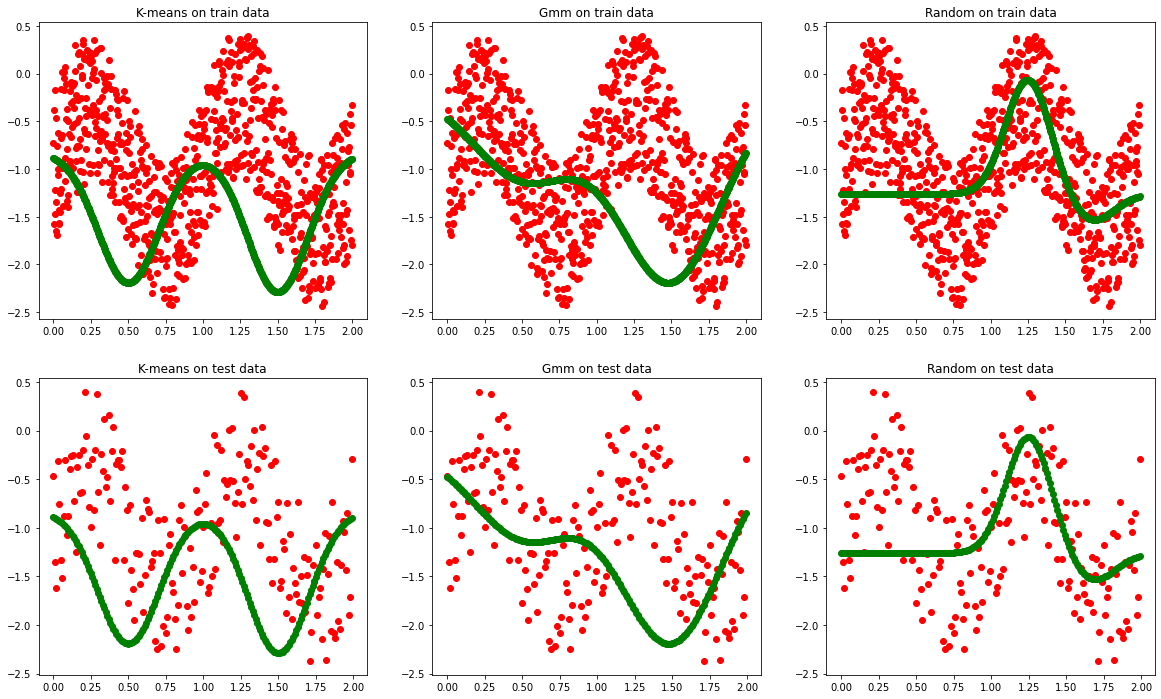

In [103]:
# k-means
k_means = RBFNetwork(cluster_method='kmeans')
k_means.fit(x_train_rbf, y_train_rbf)
y_train_predict_kmeans = k_means.predict(x_train_rbf)
y_test_predict_kmeans = k_means.predict(x_test_rbf)

# GMM
gmm = RBFNetwork(cluster_method='gmm')
gmm.fit(x_train_rbf, y_train_rbf)
y_train_predict_gmm = gmm.predict(x_train_rbf)
y_test_predict_gmm = gmm.predict(x_test_rbf)

# Random
random = RBFNetwork(cluster_method='random')
random.fit(x_train_rbf, y_train_rbf)
y_train_predict_random = random.predict(x_train_rbf)
y_test_predict_random = random.predict(x_test_rbf)

# Plot
plt.rcParams["figure.figsize"] = (20,12) 
plt.subplot(2,3,1)
plt.scatter(x_train_rbf, y_train_rbf, c='r')
plt.scatter(x_train_rbf, y_train_predict_kmeans, c='g')
plt.title("K-means on train data")

plt.subplot(2,3,2)
plt.scatter(x_train_rbf, y_train_rbf, c='r')
plt.scatter(x_train_rbf, y_train_predict_gmm, c='g')
plt.title("Gmm on train data")

plt.subplot(2,3,3)
plt.scatter(x_train_rbf, y_train_rbf, c='r')
plt.scatter(x_train_rbf, y_train_predict_random, c='g')
plt.title("Random on train data")

plt.subplot(2,3,4)
plt.scatter(x_test_rbf, y_test_rbf, c='r')
plt.scatter(x_test_rbf, y_test_predict_kmeans, c='g')
plt.title("K-means on test data")

plt.subplot(2,3,5)
plt.scatter(x_test_rbf, y_test_rbf, c='r')
plt.scatter(x_test_rbf, y_test_predict_gmm, c='g')
plt.title("Gmm on test data")

plt.subplot(2,3,6)
plt.scatter(x_test_rbf, y_test_rbf, c='r')
plt.scatter(x_test_rbf, y_test_predict_random, c='g')
plt.title("Random on test data")

### MLP

7/7 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'MLP on test data')

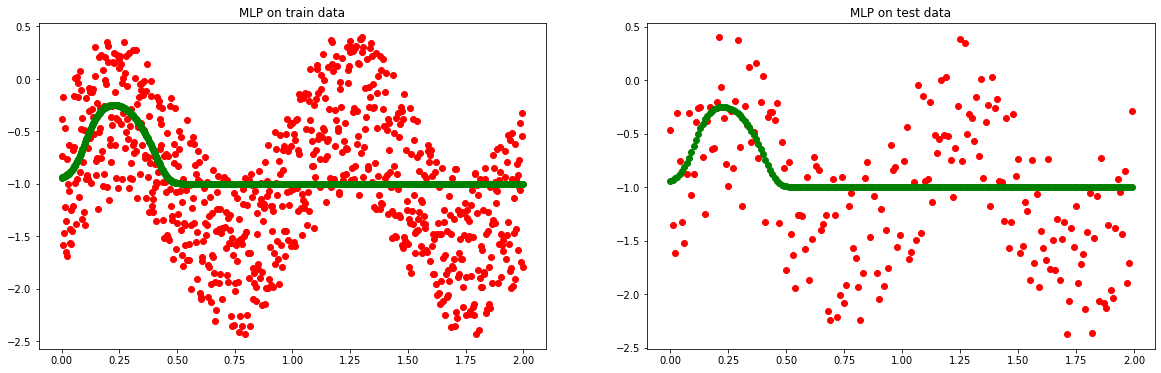

In [119]:
plt.rcParams["figure.figsize"] = (20,6) 

model = Sequential()
model.add(Dense(32, input_shape=(1,), activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=500, verbose=0)

y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

plt.subplot(1,2,1)
plt.scatter(x_train, y_train, c='r')
plt.scatter(x_train, y_train_predict, c='g')
plt.title("MLP on train data")

plt.subplot(1,2,2)
plt.scatter(x_test, y_test,c='r')
plt.scatter(x_test, y_test_predict, c='g')
plt.title("MLP on test data")